In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_rel
%matplotlib inline

In [2]:
os.makedirs('plots', exist_ok=True)
df = pd.read_csv('routing_comparison_500_trips_all.csv')
print(df.head())
print(df.describe())

   start_lat  start_lon    end_lat    end_lon  dijkstra_min  a_star_min  \
0  60.187432  24.737756  60.227143  24.834923            32          28   
1  60.149337  24.722714  60.217055  24.775019            37          42   
2  60.255423  24.892225  60.241304  24.804445            38          62   
3  60.163351  24.791435  60.190117  24.653618            47          99   
4  60.153307  24.929899  60.200965  24.871054            47          57   

   otp_min  google_maps_min  distance_km start_time  
0      115               30          7.0      14:02  
1      132              117          8.1      14:03  
2       79               61          5.1      13:59  
3      136              145          8.2      20:40  
4      101               89          6.2      20:45  
        start_lat   start_lon     end_lat     end_lon  dijkstra_min  \
count  404.000000  404.000000  404.000000  404.000000    404.000000   
mean    60.219211   24.835225   60.220883   24.829052     39.987624   
std      0.0

In [3]:
df['dijkstra_min'] = df['dijkstra_min'].clip(upper=150)
df['a_star_min'] = df['a_star_min'].clip(upper=150)
df['otp_min'] = df['otp_min'].clip(upper=150)
df['google_maps_min'] = df['google_maps_min'].clip(upper=150)

In [4]:
bins = [0, 1, 2, 5, float('inf')]
labels = ['<1 km', '1-2 km', '2-5 km', '>5 km']
df['distance_category'] = pd.cut(df['distance_km'], bins=bins, labels=labels)

/var/folders/kr/5g0gwgjd7zs7srh5jt0mqn4r0000gn/T/ipykernel_9174/2973809256.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  comparison = df.groupby('distance_category').agg({


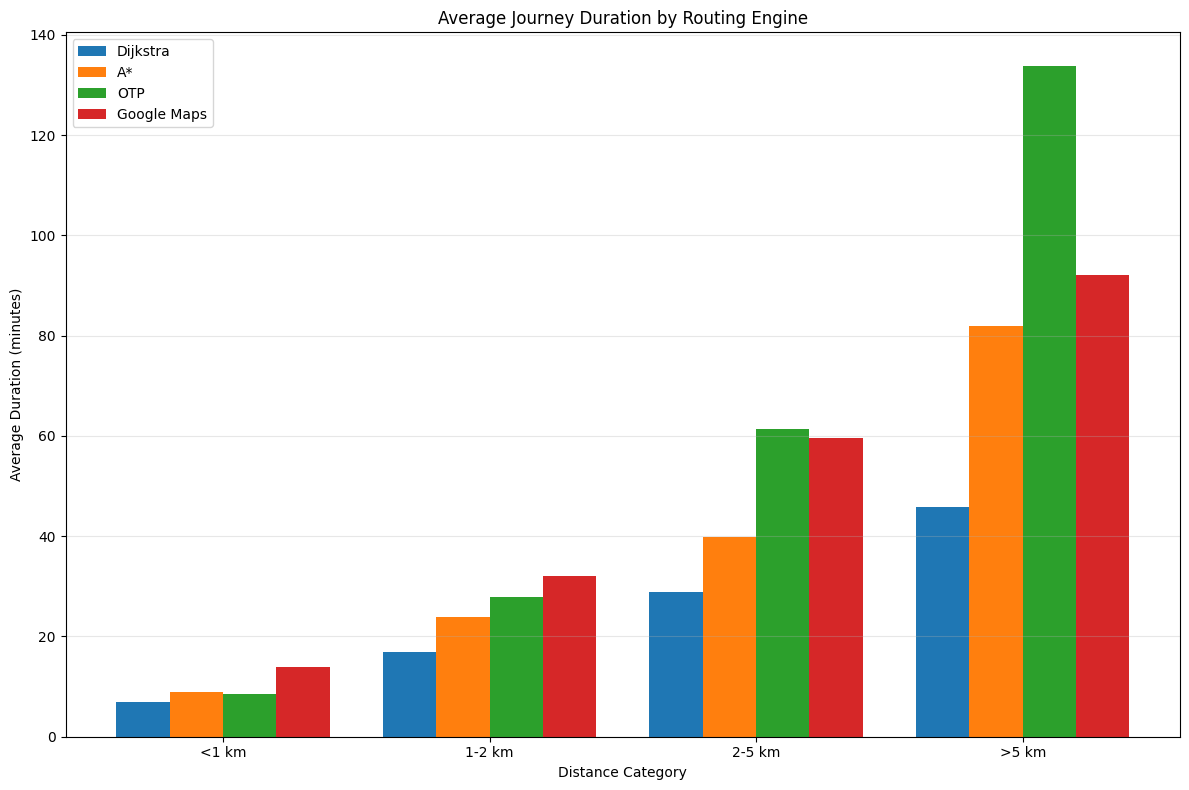

In [5]:
plt.figure(figsize=(12, 8))
comparison = df.groupby('distance_category').agg({
    'dijkstra_min': 'mean',
    'a_star_min': 'mean',
    'otp_min': 'mean',
    'google_maps_min': 'mean',
    'distance_km': 'mean'
}).reset_index()

x = np.arange(len(labels))
width = 0.2

plt.bar(x - width * 1.5, comparison['dijkstra_min'], width, label='Dijkstra', color='#1f77b4')
plt.bar(x - width / 2, comparison['a_star_min'], width, label='A*', color='#ff7f0e')
plt.bar(x + width / 2, comparison['otp_min'], width, label='OTP', color='#2ca02c')
plt.bar(x + width * 1.5, comparison['google_maps_min'], width, label='Google Maps', color='#d62728')

plt.xlabel('Distance Category')
plt.ylabel('Average Duration (minutes)')
plt.title('Average Journey Duration by Routing Engine')
plt.xticks(x, labels)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('plots/avg_duration_comparison.png', dpi=300)
plt.show()

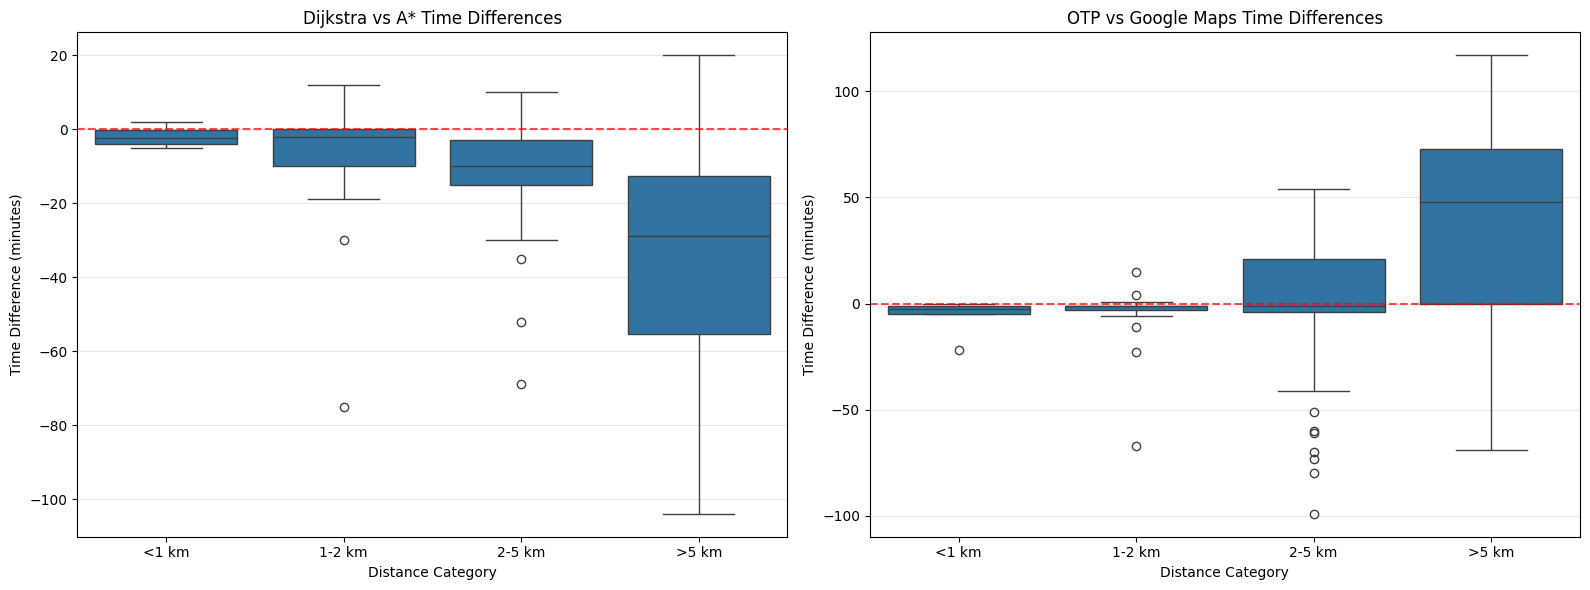

In [6]:
df['dijkstra_astar_diff'] = df['dijkstra_min'] - df['a_star_min']
df['otp_google_diff'] = df['otp_min'] - df['google_maps_min']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='distance_category', y='dijkstra_astar_diff', data=df, ax=ax1)
ax1.axhline(0, color='r', linestyle='--', alpha=0.7)
ax1.set_title('Dijkstra vs A* Time Differences')
ax1.set_ylabel('Time Difference (minutes)')
ax1.set_xlabel('Distance Category')
ax1.grid(axis='y', alpha=0.3)

sns.boxplot(x='distance_category', y='otp_google_diff', data=df, ax=ax2)
ax2.axhline(0, color='r', linestyle='--', alpha=0.7)
ax2.set_title('OTP vs Google Maps Time Differences')
ax2.set_ylabel('Time Difference (minutes)')
ax2.set_xlabel('Distance Category')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/pairwise_differences.png', dpi=300)
plt.show()

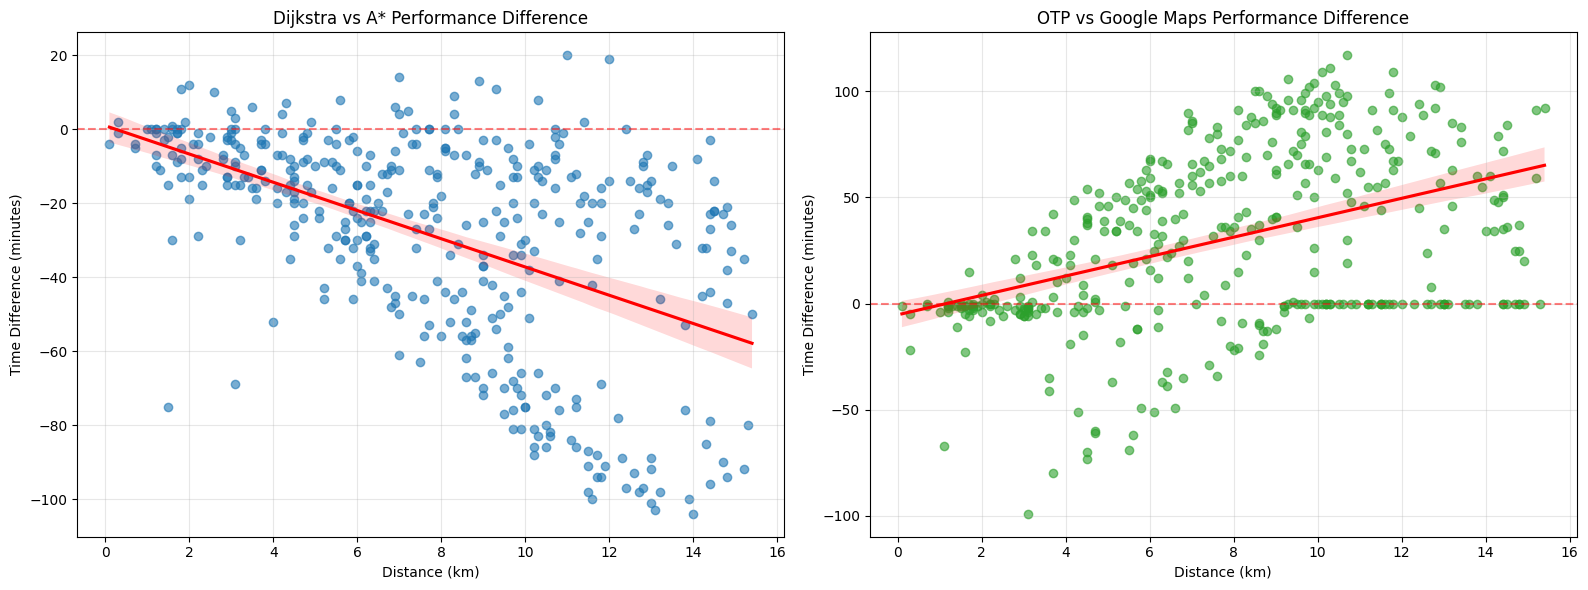

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.regplot(x='distance_km', y='dijkstra_astar_diff', data=df, ax=ax1,
            scatter_kws={'alpha': 0.6, 'color': '#1f77b4'},
            line_kws={'color': 'red'})
ax1.axhline(0, color='r', linestyle='--', alpha=0.5)
ax1.set_title('Dijkstra vs A* Performance Difference')
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Time Difference (minutes)')
ax1.grid(alpha=0.3)

sns.regplot(x='distance_km', y='otp_google_diff', data=df, ax=ax2,
            scatter_kws={'alpha': 0.6, 'color': '#2ca02c'},
            line_kws={'color': 'red'})
ax2.axhline(0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('OTP vs Google Maps Performance Difference')
ax2.set_xlabel('Distance (km)')
ax2.set_ylabel('Time Difference (minutes)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/distance_performance_difference.png', dpi=300)
plt.show()


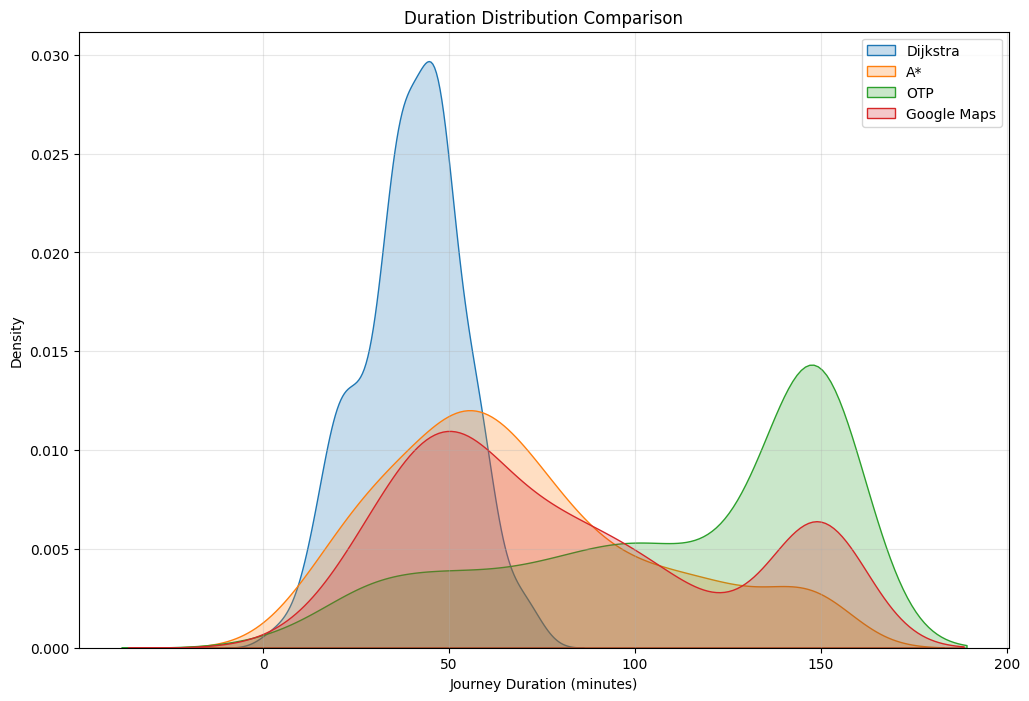

In [8]:
plt.figure(figsize=(12, 8))
sns.kdeplot(df['dijkstra_min'], label='Dijkstra', fill=True)
sns.kdeplot(df['a_star_min'], label='A*', fill=True)
sns.kdeplot(df['otp_min'], label='OTP', fill=True)
sns.kdeplot(df['google_maps_min'], label='Google Maps', fill=True)
plt.title('Duration Distribution Comparison')
plt.xlabel('Journey Duration (minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('plots/duration_distribution.png', dpi=300)
plt.show()

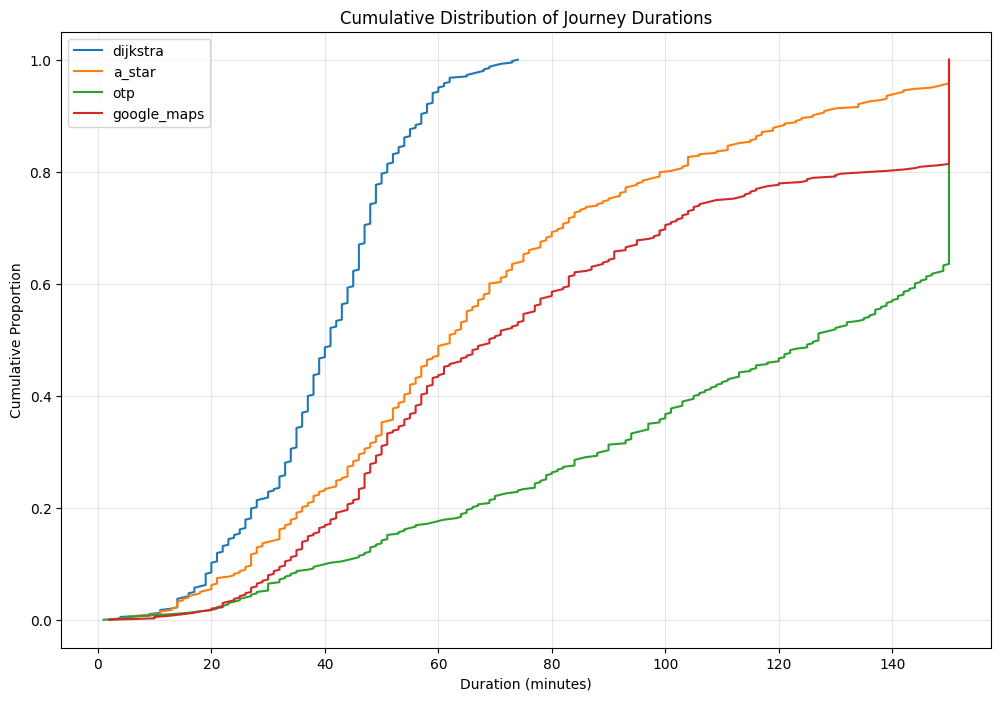

In [9]:
plt.figure(figsize=(12, 8))
for algorithm in ['dijkstra_min', 'a_star_min', 'otp_min', 'google_maps_min']:
    sorted_times = np.sort(df[algorithm])
    plt.plot(sorted_times, np.linspace(0, 1, len(sorted_times)), label=algorithm.replace('_min', ''))

plt.title('Cumulative Distribution of Journey Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Cumulative Proportion')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('plots/cumulative_performance.png', dpi=300)
plt.show()